<a href="https://colab.research.google.com/github/martinpius/Applied-Predictive-Modeling2/blob/master/STOCK_PREDICTIONS_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from google.colab import drive
try:
  drive.mount("/content/drive", force_remount = True)
  COLAB = True
  import tensorflow
  print(f"You are using Google Colab with tensorflow version: {tensorflow.__version__}")
except:
  COLAB = False
  pass

Mounted at /content/drive
You are using Google Colab with tensorflow version: 2.3.0


In [26]:
def time_setter(x):
  hours = int(x/(60 * 60))
  minutes = int(x%(60 * 60)/60)
  seconds = int(x % 60)
  return f"{hours}:{minutes:>02}:{seconds:>05.2f}"

In [27]:
import pandas_datareader as pdr
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import time
from tensorflow.keras.layers import Dense, BatchNormalization, LSTM, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

In [28]:
#Pool data from the web
key = '82fb91fcd8a2a58207051b9ce67986fb06df5a9499999fg3898rr'
data = pdr.get_data_tiingo('AAPL', api_key = key)
data.to_csv('AAPL.csv')

In [29]:
mydata = pd.read_csv('AAPL.csv', na_values = ['NA','?'])

In [30]:
display(mydata.head(10))

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2015-11-02 00:00:00+00:00,121.18,121.36,119.610,119.87,32203267,27.992000,28.033579,27.629338,27.689396,128813068,0.00,1.0
1,AAPL,2015-11-03 00:00:00+00:00,122.57,123.49,120.700,120.79,45518976,28.313084,28.525599,27.881122,27.901912,182075904,0.00,1.0
2,AAPL,2015-11-04 00:00:00+00:00,122.00,123.82,121.620,123.13,44886050,28.181416,28.601828,28.093638,28.442441,179544200,0.00,1.0
3,AAPL,2015-11-05 00:00:00+00:00,120.92,122.69,120.180,121.85,39552680,28.052059,28.462679,27.880387,28.267808,158210720,0.52,1.0
4,AAPL,2015-11-06 00:00:00+00:00,121.06,121.81,120.620,121.11,33042283,28.084537,28.258529,27.982462,28.096137,132169132,0.00,1.0
5,AAPL,2015-11-09 00:00:00+00:00,120.57,121.81,120.050,120.96,33871405,27.970863,28.258529,27.850229,28.061338,135485620,0.00,1.0
6,AAPL,2015-11-10 00:00:00+00:00,116.77,118.07,116.061,116.90,59127931,27.089306,27.390891,26.924826,27.119465,236511724,0.00,1.0
7,AAPL,2015-11-11 00:00:00+00:00,116.11,117.42,115.210,116.37,45217971,26.936194,27.240099,26.727404,26.996511,180871884,0.00,1.0
8,AAPL,2015-11-12 00:00:00+00:00,115.72,116.82,115.650,116.26,32525579,26.845718,27.100906,26.829479,26.970992,130102316,0.00,1.0
9,AAPL,2015-11-13 00:00:00+00:00,112.34,115.57,112.270,115.20,45812403,26.061597,26.810920,26.045358,26.725084,183249612,0.00,1.0


In [31]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

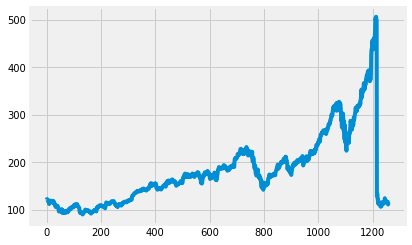

In [32]:
mydata['close'].plot()

In [33]:
closeP = mydata['close']

In [34]:
closeP = np.array(closeP)

In [35]:
scaler = MinMaxScaler(feature_range=(0,1))
closeP = scaler.fit_transform(closeP.reshape(-1,1))

In [36]:
closeP

array([[0.07417919],
       [0.07752255],
       [0.07615153],
       ...,
       [0.06316296],
       [0.05017438],
       [0.06008419]])

In [37]:
size_train = int(len(closeP)*0.80) #80% training examples
size_test = len(closeP) - size_train

In [38]:
train = closeP[0:size_train,:]
test = closeP[size_train:len(closeP),:1]

In [39]:
train[0:4]

array([[0.07417919],
       [0.07752255],
       [0.07615153],
       [0.07355382]])

In [40]:
test[0:5]

array([[0.3810463 ],
       [0.39802766],
       [0.40206855],
       [0.40117859],
       [0.40144317]])

In [46]:
#Create the lists of sequences:
def data_maker(dfm, time_step = 1):
  X, Y = [], []
  for i in range(len(dfm)-time_step -1):
    a = dfm[i:(i+time_step),0]
    X.append(a)
    Y.append(dfm[i+time_step, 0])
  return np.array(X), np.array(Y)

In [54]:
time_step = 100
x_train, y_train = data_maker(train, time_step)
x_test, y_test = data_maker(test, time_step)

In [55]:
#Reshaping the data
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [56]:
print(f"X_train_shape: {x_train.shape}\nX_test_shape: {x_test.shape}")

X_train_shape: (905, 100, 1)
X_test_shape: (151, 100, 1)


In [57]:
#Building stacked LSTM for closed price data.
model = Sequential()
model.add(LSTM(units = 256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape = (100,1)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'Adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 256)          264192    
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 256)          1024      
_________________________________________________________________
dropout (Dropout)            (None, 100, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           61400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 346,867
Trainable params: 346,355
Non-trainable params: 512
________________________________________________

In [58]:
info = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True, verbose = 1, mode = 'auto', min_delta = 1e-3)
model.fit(x_train, y_train, validation_data = (x_test, y_test), verbose = 2, callbacks =[info], epochs = 100,batch_size = 64)

Epoch 1/100
15/15 - 11s - loss: 0.0219 - val_loss: 0.1637
Epoch 2/100
15/15 - 10s - loss: 0.0022 - val_loss: 0.1598
Epoch 3/100
15/15 - 10s - loss: 0.0011 - val_loss: 0.1657
Epoch 4/100
15/15 - 10s - loss: 9.6257e-04 - val_loss: 0.1709
Epoch 5/100
15/15 - 10s - loss: 9.0401e-04 - val_loss: 0.1708
Epoch 6/100
15/15 - 10s - loss: 0.0011 - val_loss: 0.1729
Epoch 7/100
Restoring model weights from the end of the best epoch.
15/15 - 10s - loss: 9.0431e-04 - val_loss: 0.1722
Epoch 00007: early stopping


In [67]:
pred = model.predict(x_test)
pred = scaler.inverse_transform(pred) #Restore the previous format

In [68]:
mse = np.sqrt(metrics.mean_squared_error(y_test, pred))

In [69]:
mse

167.75942682627866